In [1]:
from google.colab import files
uploaded = files.upload()

Saving pneumoniamnist.npz to pneumoniamnist.npz


In [2]:
import numpy as np
#load pneumoniamnist dataset
pneumoniamnist = np.load('pneumoniamnist.npz')

In [3]:
pneumoniamnist['train_images'].shape, pneumoniamnist['train_labels'].shape

((3882, 28, 28), (3882, 1))

In [4]:
(x_train, y_train), (x_test, y_test) = (pneumoniamnist['train_images'], pneumoniamnist['train_labels']), (pneumoniamnist['test_images'], pneumoniamnist['test_labels'])
(x_val, y_val) = (pneumoniamnist['val_images'], pneumoniamnist['val_labels'])

#print(x_train.shape)  # (4708, 28, 28)
#print(y_train.shape)  # (4708, 1)
#print(y_train[40:50])  # class-label

#print(x_test.shape)  # (624, 28, 28)
#print(y_test.shape)  # (624, 1)

In [5]:

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# rescale value to [0 - 1] from [0 - 255]
x_train /= 255  # rescaling
x_test /= 255   # rescaling

x_val = x_val.astype('float32')/255

In [6]:
x_train.shape+(1,)

(3882, 28, 28, 1)

In [7]:
x_train = np.expand_dims(x_train, axis=3)
print('x_train shape:',x_train.shape)
x_test = np.expand_dims(x_test, axis=3)
print('x_test shape:',x_test.shape)
x_val = np.expand_dims(x_val, axis=3)
print('x_val shape:',x_val.shape)

x_train shape: (3882, 28, 28, 1)
x_test shape: (624, 28, 28, 1)
x_val shape: (524, 28, 28, 1)


In [8]:
num_classes = 2

from tensorflow.keras.utils import to_categorical
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)
y_val_onehot = to_categorical(y_val)

print('y_train_onehot shape:', y_train_onehot.shape)
print('y_test_onehot shape:', y_test_onehot.shape)
print('y_val_onehot shape:', y_val_onehot.shape)

y_train_onehot shape: (3882, 2)
y_test_onehot shape: (624, 2)
y_val_onehot shape: (524, 2)


In [9]:
# Ensure image format: resize + grayscale to RGB
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout,Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


x_train = tf.image.resize(x_train, [96, 96])
x_train = tf.image.grayscale_to_rgb(x_train)
x_val = tf.image.resize(x_val, [96, 96])
x_val = tf.image.grayscale_to_rgb(x_val)
x_test = tf.image.resize(x_test, [96, 96])
x_test = tf.image.grayscale_to_rgb(x_test)

x_train = x_train.numpy()
x_val = x_val.numpy()
x_test = x_test.numpy()

num_classes = y_train_onehot.shape[1]

input = Input(shape=x_train.shape[1:])
base_model = InceptionV3 (weights='imagenet', include_top=False, input_tensor=input)
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu',kernel_regularizer=l2(0.001))(x) #one more hidden layer
output = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=input, outputs=output)

opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [10]:
cnn_history = model.fit(x_train, y_train_onehot,
                  batch_size=8,
                  epochs=20,
                  validation_data=(x_val, y_val_onehot))

Epoch 1/15
486/486 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.9147 - loss: 0.4729 - val_accuracy: 0.8989 - val_loss: 0.4062
Epoch 2/15
486/486 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.9467 - loss: 0.2903 - val_accuracy: 0.8760 - val_loss: 0.4653
Epoch 3/15
486/486 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9488 - loss: 0.2595 - val_accuracy: 0.8912 - val_loss: 0.3880
Epoch 4/15
486/486 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9612 - loss: 0.2329 - val_accuracy: 0.9046 - val_loss: 0.3646
Epoch 5/15
486/486 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9661 - loss: 0.2044 - val_accuracy: 0.8931 - val_loss: 0.3707
Epoch 6/15
486/486 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9640 - loss: 0.1992 - val_accuracy: 0.8912 - val_loss: 0.3532
Epoch 7/15
486/486 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9741 - loss: 0.1792 - val_accuracy: 0.9065 - val_loss: 0.3332
Epoch 8/15
486/486 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9633 - loss: 0.1767 - va

In [11]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter( y=cnn_history.history['accuracy'],
              name='Train'))
fig.add_trace(go.Scatter( y=cnn_history.history['val_accuracy'],
              name='Valid'))
fig.update_layout(height=500,width=700,
              title='Accuracy for race feature',
              xaxis_title='Epoch',
              yaxis_title='Accuracy')
fig.show()

<Figure size 640x480 with 0 Axes>

In [12]:
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)


20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 390ms/step


In [13]:
import numpy as np

y_pred = np.argmax(y_pred_prob, axis=1)

# Also convert y_test_onehot to class indices if needed
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test_labels = np.argmax(y_test, axis=1)
else:
    y_test_labels = y_test


              precision    recall  f1-score   support

      normal       0.94      0.44      0.60       234
   pneumonia       0.74      0.98      0.85       390

    accuracy                           0.78       624
   macro avg       0.84      0.71      0.72       624
weighted avg       0.82      0.78      0.75       624

**************************************************************


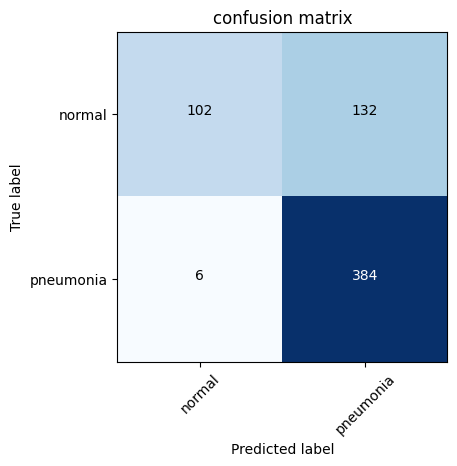

In [14]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools

classes = ['normal','pneumonia']
print(classification_report(y_test, y_pred, target_names=classes))

print ("**************************************************************")

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,5))
plt.title('confusion matrix')
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = 'd' #'.2f'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

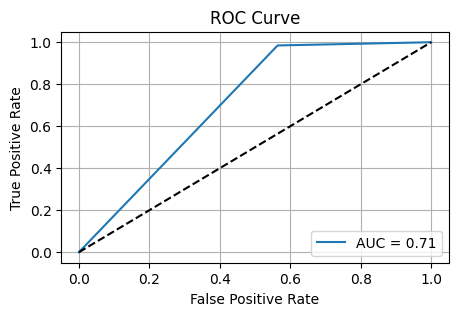

In [15]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

plt.figure(figsize=(5, 3))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()